In [ ]:
import numpy as np
import random
from PIL import Image
import os
import re
import copy
import pandas as pd
import matplotlib.pyplot as plt

# Generating train data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json file C:\Users\Admin\.kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saran4a","key":"202314c43454b8ff95a53fcb9adbe2bc"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.2MB/s]
 76% 7.00M/9.16M [00:00<00:00, 69.4MB/s]
100% 9.16M/9.16M [00:00<00:00, 58.4MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 62.6MB/s]


In [ ]:
! mkdir train
! unzip train.csv.zip -d train
# The training data set, (train.csv), has 785 columns. The first column, called "label", 
# is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
# Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive.
# To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. 
# Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

Archive:  train.csv.zip
  inflating: train/train.csv         


In [ ]:
train = pd.read_csv('/content/train/train.csv')
# train.head(20)
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
digits = range(10)
rows = np.zeros(10)
for i in range(10):
  j = 0
  while (i != train.at[j, 'label']):
    j+=1
  rows[i] = j
rows = [int(row) for row in rows]
print('rows = ', rows)
print('rows - номер строки первого элемента в train со значением i, i=0,9')

rows =  [1, 0, 16, 7, 3, 8, 21, 6, 10, 11]
rows - номер строки первого элемента в train со значением i, i=0,9


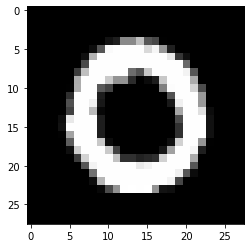

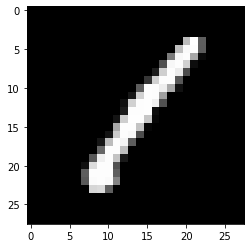

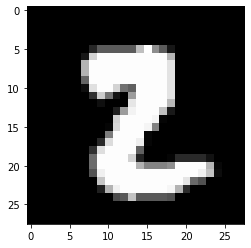

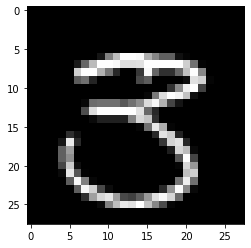

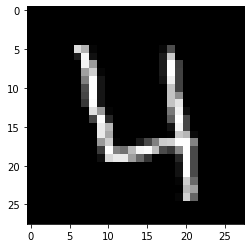

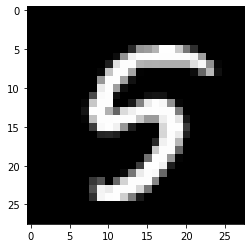

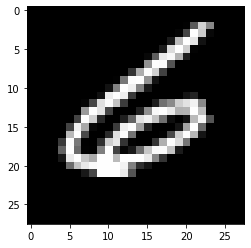

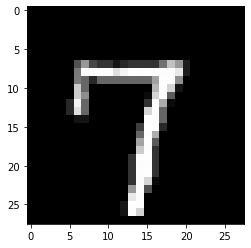

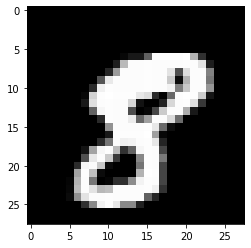

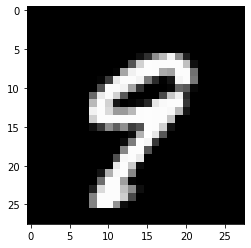

In [ ]:
def get_x(x): 
    return x.values.reshape(28, 28)
train_data = train.iloc[rows, range(1,785)]
for row in rows:
  plt.figure()
  plt.imshow(get_x(train_data.loc[row]), cmap = 'gray')

In [ ]:
train_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
 def preprocess(array, threshold = 145):
    x = np.zeros(array.shape,dtype=np.float)
    x[array > threshold] = 1
    x[x==0] = -1
    return x

In [ ]:
train_data_new = np.empty((10, 784))
for i in range(10):
     train_vec = train_data.iloc[i].values
     train_data_new[i] = preprocess(train_vec.reshape(28,28)).reshape(1,784)

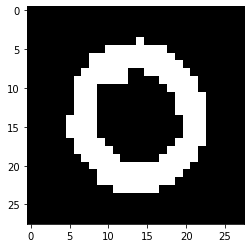

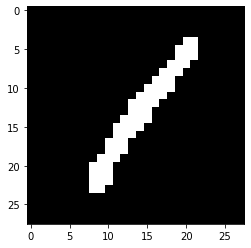

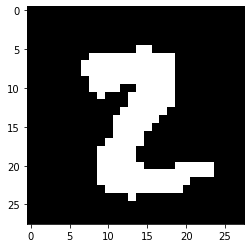

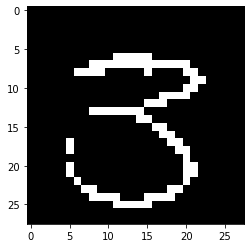

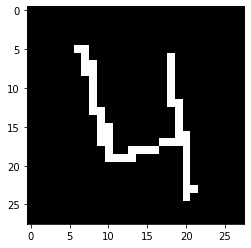

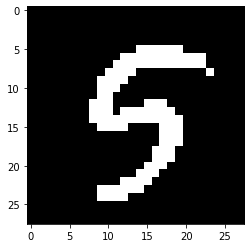

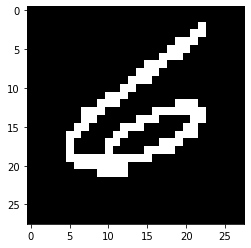

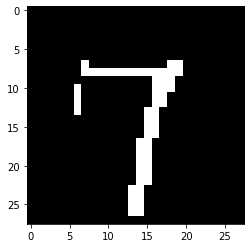

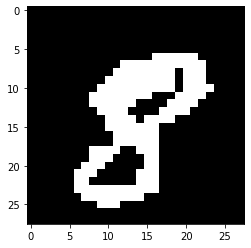

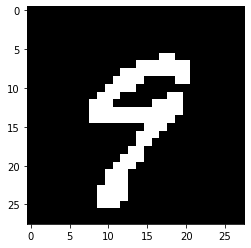

In [ ]:
for sample in train_data_new:
  plt.figure()
  plt.imshow(sample.reshape(28,28), cmap = 'gray')

# Generating test data (through filters)



In [ ]:
from skimage.exposure import rescale_intensity
import argparse
import cv2

In [ ]:
def convolve(image, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]
	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
	pad = (kW - 1) // 2
	image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
	output = np.zeros((iH, iW), dtype="float32")
  # loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to
	# bottom
	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			# extract the ROI of the image by extracting the
			# *center* region of the current (x, y)-coordinates
			# dimensions
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
			# perform the actual convolution by taking the
			# element-wise multiplicate between the ROI and
			# the kernel, then summing the matrix
			k = (roi * kernel).sum()
			# store the convolved value in the output (x,y)-
			# coordinate of the output image
			output[y - pad, x - pad] = k
  # rescale the output image to be in the range [0, 255]
	output = rescale_intensity(output, in_range=(0, 255))
	output = (output * 255).astype("uint8")
	# return the output image
	return output

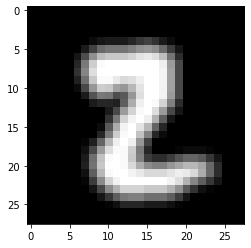

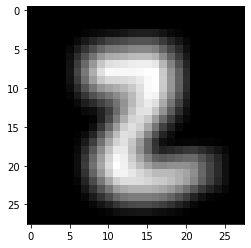

In [ ]:
a = get_x(train_data.iloc[2])
smallBlur = np.ones((3, 3), dtype="float") * (1.0 / (7 * 7))
bigBlur = np.ones((5, 5), dtype="float") * (1.0 / (7 * 7))
plt.figure()
new_array_smallBlur = convolve(a, smallBlur)
plt.imshow(new_array_smallBlur, cmap = 'gray')
plt.figure()
new_array_bigBlur = convolve(a, bigBlur)
plt.imshow(new_array_bigBlur, cmap = 'gray')

In [ ]:
from random import choice
def blurring(vec):
  sizes = [2, 3]
  kernel_size = choice(sizes)
  blur = np.ones((kernel_size, kernel_size), dtype="float") * (1.0 / (10 * 10))
  return convolve(vec.reshape(28,28), blur)

In [ ]:
train_04 = [get_x(train_data.iloc[ind]) for ind, row in enumerate(rows[0:5])]
test_data = []
for digit in train_04:
  i=1
  for n_sample in range(100*(i-1),100*i):  
    # plt.figure()
    blurred = blurring(digit)
    # plt.imshow(blurred, cmap='gray')
    test_data.append(blurred)
  i+=1

In [ ]:
for i in train_04:
  plt.figure()
  plt.imshow(i, cmap='gray')

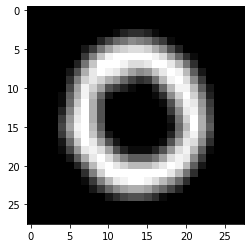

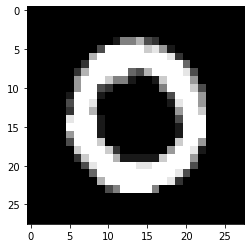

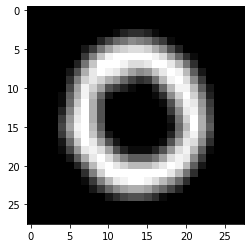

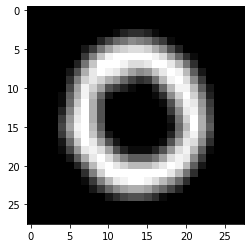

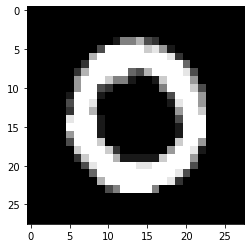

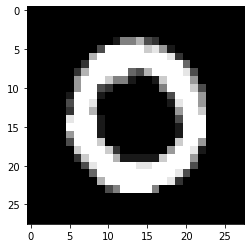

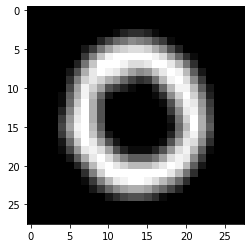

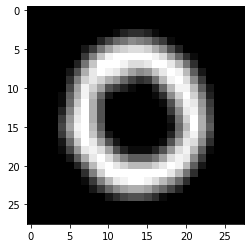

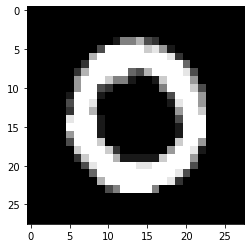

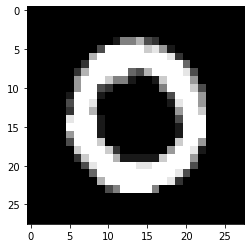

In [ ]:
for n_sample in test_data[0:10]:
  plt.figure()
  plt.imshow(n_sample, cmap='gray')

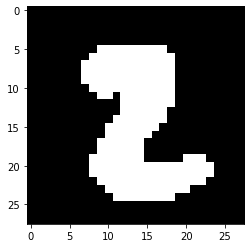

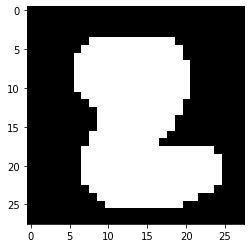

In [ ]:
plt.figure()
new_array_smallBlur = preprocess(convolve(a, smallBlur), 15)
plt.imshow(new_array_smallBlur, cmap = 'gray')
plt.figure()
new_array_bigBlur = preprocess(convolve(a, bigBlur), 15)
plt.imshow(new_array_bigBlur, cmap = 'gray')

# Building model

In [ ]:
def hopfield_one(train_data, test_data):  #train_data - список векторов, test_data - список матриц
  # train
  num = 0
  for i in range(len(train_data)):
     #train_vec = train_data.loc[row].values
     train_vec = train_data[i]
     if num == 0:
       w = create_W(train_vec)
       num = 1
     else:
       tmp_w = create_W(train_vec)
       w = w + tmp_w
       num += 1
  # test
  output = np.empty((len(test_data), 784))
  i=0
  for test_vec in test_data:
    test_vec = mat2vec(test_vec)
    test_vec_after = update(w=w,y_vec=test_vec)
    # test_vec_after = test_vec_after.reshape((28,28))
    y = np.zeros(test_vec_after.shape,dtype=np.uint8)
    y[test_vec_after==1] = 255
    y[test_vec_after==-1] = 0
    output[i] = y
    i += 1
  return output  # список векторов (1,784)

In [ ]:
def mat2vec(x):
    m = x.shape[0]*x.shape[1]
    tmp1 = np.zeros(m)

    c = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tmp1[c] = x[i,j]
            c +=1
    return tmp1

In [ ]:
def create_W(x):
    if len(x.shape) != 1:
        print("The input is not vector")
        return
    else:
        w = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(i,len(x)):
                if i == j:
                    w[i,j] = 0
                else:
                    w[i, j] = x[i]*x[j]
                    w[j, i] = w[i, j]
    return w

In [ ]:
def update(w,y_vec):
    current_state = copy.deepcopy(y_vec)
    while True:
        previous_state = copy.deepcopy(current_state)
        for row_ind, row in enumerate(w):
            sum = 0
            for col_id, col in enumerate(row):
                sum += col*previous_state[col_id]
            if sum >= 0:
                current_state[row_ind] = 1
            else:
                current_state[row_ind] = -1
        if np.array_equal(current_state, previous_state):
            break
    return current_state

# Results

In [ ]:
results = hopfield_one(train_data_new[0:4], [new_array_smallBlur, new_array_bigBlur])

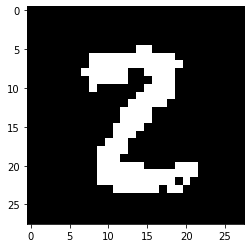

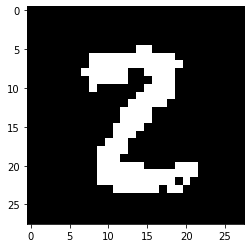

In [ ]:
for res in results:
  plt.figure()
  plt.imshow(res.reshape((28,28)), cmap = 'gray')

# Analysis

In [ ]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out
  elif (noise_typ == "poisson"):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

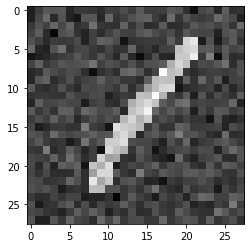

In [ ]:
one = noisy('gauss', train_data_new[1].reshape(28,28, 1))
plt.imshow(one.reshape(28,28), cmap='gray')

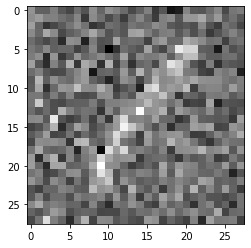

In [ ]:
one = noisy('speckle', train_data_new[1].reshape(28,28, 1))
plt.imshow(one.reshape(28,28), cmap='gray')

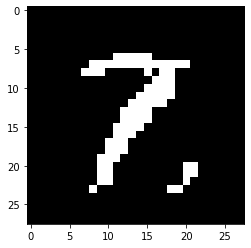

In [ ]:
plt.imshow(hopfield_one(train_data_new[0:4], [one]).reshape(28,28), cmap='gray')
